In [4]:
import os

# Enable MPS for the Python process
os.environ['TF_MPS'] = '1'

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn
from sklearn.metrics import f1_score, classification_report,confusion_matrix
import uuid
from carbontracker.tracker import CarbonTracker
from codecarbon import track_emissions

In [6]:
# Define data directories
data_dir = '../data/'  

In [7]:

# Define the class names
class_names = ['buffalo','eland', 'elephant','giraffe','hyaenabrown','impala','leopard','lion','rhino', 'zebra']

In [8]:
# Define data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    zoom_range=0.2,
)

# Load and preprocess training data
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=64,
    class_mode='categorical',
    classes=class_names,
    subset='training',
    shuffle=True,
    seed=42,
)

Found 56446 images belonging to 10 classes.


In [9]:
# Load and preprocess test data
valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2                 
)
valid_data = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=64,
    class_mode='categorical',
    classes=class_names,
    subset='validation',
    shuffle=False,
)

Found 14106 images belonging to 10 classes.


In [10]:
# Create the base model with pre-trained weights (InceptionV3)
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(299, 299, 3),
    pooling='avg',
    classifier_activation='softmax',
)

# Add custom classification layers on top of the base model
x = base_model.output
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 2

In [11]:
@track_emissions()
def training(train_data,epochs,validation_data):
    return model.fit(train_data, epochs=num_epochs, validation_data=valid_data)

In [ ]:
history = training(train_data=train_data,epochs=num_epochs,validation_data=valid_data)

In [ ]:
# Get the number of epochs
epochs = len(history.history['accuracy'])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['accuracy'])
plt.plot(range(1, epochs + 1), history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history.history['loss'])
plt.plot(range(1, epochs + 1), history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
valid_data.reset()
y_pred = model.predict(valid_data, steps=np.ceil(valid_data.samples / 64))
y_true = valid_data.classes

f1 = f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')
print(f"F1 Score : {f1}")

In [12]:
print("Classification Report:")
print(classification_report(y_true, np.argmax(y_pred, axis=1)))

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.03      0.05       647
           1       0.72      0.13      0.22       718
           2       0.43      0.90      0.58      1485
           3       0.99      0.77      0.86      1124
           4       1.00      0.28      0.43       599
           5       0.85      0.96      0.90      5903
           6       0.36      0.80      0.49       230
           7       0.77      0.10      0.18       196
           8       0.57      0.18      0.27       814
           9       0.96      0.92      0.94      2390

    accuracy                           0.76     14106
   macro avg       0.70      0.51      0.49     14106
weighted avg       0.79      0.76      0.72     14106



In [13]:
confusion = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

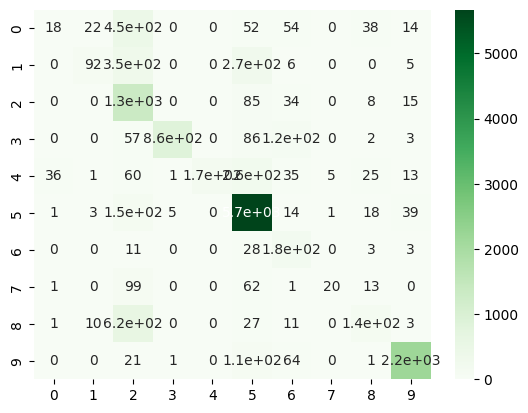

In [14]:
seaborn.heatmap(confusion, cmap='Greens', annot=True)
plt.show()

In [15]:
model.save('../models/tinyml.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# Save the model in TensorFlow Lite format
tflite_model_path = '../models/tinyml_model.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/vq/g110rjmd53bg177m6tkp18d00000gn/T/tmpo85472s3/assets


INFO:tensorflow:Assets written to: /var/folders/vq/g110rjmd53bg177m6tkp18d00000gn/T/tmpo85472s3/assets
2023-11-25 00:31:48.254398: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-25 00:31:48.254542: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


In [17]:
test_dir = '../../dataset/some_data/'

In [18]:
# Initialize lists to store image paths and labels
test_images = []
test_labels = []

# Loop through class names and corresponding directories
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    class_images = os.listdir(class_dir)
    num_images = len(class_images)

    for image_filename in class_images:
        image_path = os.path.join(class_dir, image_filename)
        label = class_names.index(class_name)

        test_images.append(image_path)
        test_labels.append(label)

In [19]:
# Load the TFLite model\
tflite_model_path = '../models/tinyml_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
# Perform inference on a sample image
sample_image = tf.keras.preprocessing.image.load_img(
    test_images[20], target_size=(299, 299)
)

In [21]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image = np.expand_dims(sample_image, axis=0).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], sample_image)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output)

In [22]:
predicted_class

6

In [ ]:
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class]

print(f"Predicted Class: {predicted_class_name}")


In [ ]:
#Compare the predicted label to actual label
print(f"Actual Class: {class_names[test_labels[20]]}")

In [13]:
model = tf.keras.models.load_model('../models/tinyml.h5')

In [18]:
 def representative_dataset_gen():
    for i in range(20):
        data_x, data_y = valid_data.next()
        for data_xx in data_x:
            data = tf.reshape(data_xx, shape=[-1, 299, 299, 3])
            yield [data]
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops =[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.int8
converter.inference_output_type = tf.int8
quantized_model = converter.convert()
open("../models/tinyml_model_quant.tflite", "wb").write(quantized_model)

INFO:tensorflow:Assets written to: /var/folders/vq/g110rjmd53bg177m6tkp18d00000gn/T/tmpdysckty_/assets


INFO:tensorflow:Assets written to: /var/folders/vq/g110rjmd53bg177m6tkp18d00000gn/T/tmpdysckty_/assets
/opt/homebrew/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-25 08:36:03.605847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-25 08:36:03.605877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


22557464

In [19]:
interpreter = tf.lite.Interpreter(model_content=quantized_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>
